In [1]:
import pandas as pd
import sklearn
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

## First look

In [2]:
main_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
PassengerID = test_df['PassengerId']
Survived = main_df['Survived']

In [3]:
main_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Dealing with NaNs

In [5]:
main_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
def get_rid_of_nans(df):
    df['Age'].fillna(value = df['Age'].mean(), inplace = True)
    df['Fare'].fillna(value = df['Fare'].mean(), inplace = True)
    df['Embarked'].fillna(value = df['Embarked'].mode()[0], inplace = True)
    df['Cabin'].fillna(value = 'NoCabin', inplace = True)
    re_cabin_template = "[A-Za-z]+"
    df['Cabin'] = df['Cabin'].apply(lambda x: re.search(re_cabin_template, x).group(0))

In [8]:
get_rid_of_nans(main_df)
get_rid_of_nans(test_df)

In [9]:
main_df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Feature engineering

In [10]:
def make_title(df):
    re_title_template = '([A-Za-z]+)\.'
    df['Title'] = df.Name.apply(lambda x: re.search(re_title_template, x).group(1))

In [11]:
make_title(main_df)
make_title(test_df)

In [12]:
main_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Mme           1
Jonkheer      1
Sir           1
Lady          1
Capt          1
Countess      1
Don           1
Ms            1
Name: Title, dtype: int64

In [13]:
def replace_title_name(x):
    title = x['Title']
    man_mr_titles = ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']
    woman_mrs_titles = ['Countess', 'Mme','Dona']
    woman_miss_titles = ['Mlle', 'Ms','Lady']
    if title in man_mr_titles:
        return 'Mr'
    elif title in woman_mrs_titles:
        return 'Mrs'
    elif title in woman_miss_titles:
        return 'Miss'
    elif title =='Dr':
        if x['Sex'] == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [14]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,NoCabin,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,NoCabin,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,NoCabin,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,NoCabin,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,NoCabin,S,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,NoCabin,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C,C,Dona
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NoCabin,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,NoCabin,S,Mr


In [15]:
main_df['Title'] = main_df.apply(replace_title_name, axis = 1)
test_df['Title'] = test_df.apply(replace_title_name, axis = 1)

In [16]:
main_df.Title.value_counts()

Mr        531
Miss      186
Mrs       134
Master     40
Name: Title, dtype: int64

In [17]:
test_df.Title.value_counts()

Mr        244
Miss       79
Mrs        74
Master     21
Name: Title, dtype: int64

In [18]:
def make_features(df):
    children_with_nanny = (df['Age']<18) & (df['Parch']==0)
    df['Family_Size'] = df['SibSp'] + df['Parch']
    # children without parents travell with nanny
    # df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)
    # family size and the person himself
    df['Fare_Per_Person'] = df['Fare'] / (df['Family_Size'] + 1)
    df['Age*Class'] = df['Age'] * df['Pclass']

In [19]:
make_features(main_df)
make_features(test_df)

In [20]:
def drop_columns(df):
    columns_to_drop = ['PassengerId', 'Ticket','Name', 'Cabin', 'Embarked'] # 'Cabin', 'Embarked' maybe too
    if 'Survived' in df.columns:
        columns_to_drop.append('Survived')
    df.drop(columns = columns_to_drop, inplace = True)
#     columns_to_drop = ['SibSp', 'Parch', 'Fare']
#     df.drop(columns = columns_to_drop, inplace = True)

In [21]:
drop_columns(main_df)
drop_columns(test_df)

## Data preprocessing

In [22]:
rand_state = 200

In [23]:
main_df.dtypes

Pclass               int64
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Fare               float64
Title               object
Family_Size          int64
Fare_Per_Person    float64
Age*Class          float64
dtype: object

In [24]:
def make_obj_features(df):
    obj_features = ['Pclass']
    df[obj_features] = df[obj_features].astype('object')

In [25]:
make_obj_features(test_df)
make_obj_features(main_df)

In [26]:
def encoding_columns(df):
#     LE = LabelEncoder()
#     for feature in df.select_dtypes(include = ['object']):
#         df[feature] = LE.fit_transform(df[feature])
    df = pd.get_dummies(df)
    return df

In [27]:
main_df = encoding_columns(main_df)
test_df = encoding_columns(test_df)

In [28]:
main_df_columns = set(main_df.columns)
test_df_columns = set(test_df.columns)
print(main_df_columns.difference(test_df_columns))
print(test_df_columns.difference(main_df_columns))

set()
set()


In [29]:
# main_df.drop(columns = ['Cabin_T'], inplace =True)

In [30]:
train_data, valid_data, train_value, valid_value  = train_test_split(main_df, Survived, test_size = 0.2, random_state = rand_state, shuffle = True)

# Some experiments before training in order to find out approximately which parameters are best

In [31]:
mean_cv_scores = []
std_cv_scores = []
tree_depths = []
n_depth_range = 25
for i in range(2,n_depth_range):
    rf_clsfr = RandomForestClassifier(n_estimators = 200, max_depth = i, min_samples_split = 10, 
                             min_samples_leaf = 5, random_state = rand_state, max_samples = 200)
    cv_scores = cross_val_score(rf_clsfr, train_data, train_value, cv = 5)
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    mean_cv_scores.append(mean_score)
    tree_depths.append(i)
    std_cv_scores.append(std_score)
    print("Max tree depth: {}".format(i))
    print("Mean_cv_score: {}".format(mean_score))
    print("Std_cv_score: {}".format(std_score))
    
    print(cv_scores)

Max tree depth: 2
Mean_cv_score: 0.8131882202304738
Std_cv_score: 0.025517488554329594
[0.82517483 0.81118881 0.84507042 0.81690141 0.76760563]
Max tree depth: 3
Mean_cv_score: 0.8356544863587118
Std_cv_score: 0.01530679696581805
[0.82517483 0.86013986 0.84507042 0.83098592 0.81690141]
Max tree depth: 4
Mean_cv_score: 0.8398798384713878
Std_cv_score: 0.017522565223241707
[0.83216783 0.85314685 0.86619718 0.83098592 0.81690141]
Max tree depth: 5
Mean_cv_score: 0.8384713877671626
Std_cv_score: 0.01845484976892375
[0.83916084 0.84615385 0.86619718 0.83098592 0.80985915]
Max tree depth: 6
Mean_cv_score: 0.8426967398798386
Std_cv_score: 0.01700665658307255
[0.83916084 0.84615385 0.87323944 0.83098592 0.82394366]
Max tree depth: 7
Mean_cv_score: 0.8426967398798386
Std_cv_score: 0.01700665658307255
[0.83916084 0.84615385 0.87323944 0.83098592 0.82394366]
Max tree depth: 8
Mean_cv_score: 0.8412882891756132
Std_cv_score: 0.018707936103465512
[0.83916084 0.84615385 0.87323944 0.83098592 0.816901

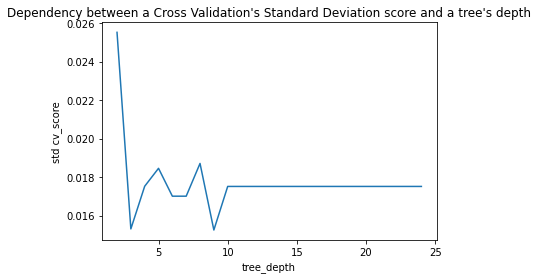

In [32]:
plt.xlabel("tree_depth")
plt.ylabel("std cv_score")
plt.title("Dependency between a Cross Validation's Standard Deviation score and a tree's depth")
plt.plot(tree_depths, std_cv_scores)

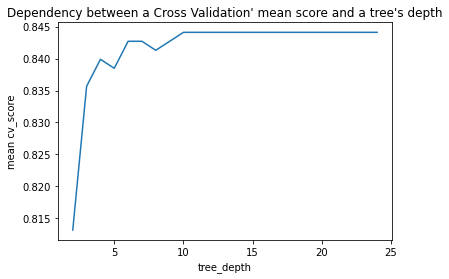

In [33]:
plt.xlabel("tree_depth")
plt.ylabel("mean cv_score")
plt.title("Dependency between a Cross Validation' mean score and a tree's depth")
plt.plot(tree_depths, mean_cv_scores)

So we may choose depth = 15 as optimal one

## Building and train a RandomForest Model

In [34]:
# 'max_samples': [200, 300, 400, 500]

In [35]:
def get_random_forest_model():
    tuned_parameters = [{'n_estimators': [300, 500, 1000],
                        'max_samples': [200, 300, 500]}]
    # min_samples_split = 6, min_samples_leaf = 2
    # RFC = RandomForestClassifier(n_estimators = 100, max_depth = 3, min_samples_split = 10, min_samples_leaf = 5, random_state = rand_state, max_samples = 200)
    Random_Forest = RandomForestClassifier(random_state = rand_state, max_depth = 19,
                                           criterion = 'entropy', min_samples_split = 10, min_samples_leaf = 5)
    RFC = GridSearchCV(Random_Forest, tuned_parameters)
    return RFC

In [36]:
RFC = get_random_forest_model()
RFC.fit(train_data, train_value)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy', max_depth=19,
                                              min_samples_leaf=5,
                                              min_samples_split=10,
                                              random_state=200),
             param_grid=[{'max_samples': [200, 300, 500],
                          'n_estimators': [300, 500, 1000]}])

## Building a Gradient Boostring ML model

In [37]:
def get_gradient_boosting_model():
    tuned_parameters = [{'n_estimators': [100, 200, 300, 500],
                        'max_depth': [5, 7, 9]}]
    Gradient_Boosting = GradientBoostingClassifier(random_state = rand_state, min_samples_split = 10,
                                                   min_samples_leaf = 5, max_features = 'sqrt', learning_rate = 0.01)
    GBC = GridSearchCV(Gradient_Boosting, tuned_parameters)
    return GBC

In [38]:
GBC = get_gradient_boosting_model()
GBC.fit(train_data, train_value)

GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  max_features='sqrt',
                                                  min_samples_leaf=5,
                                                  min_samples_split=10,
                                                  random_state=200),
             param_grid=[{'max_depth': [5, 7, 9],
                          'n_estimators': [100, 200, 300, 500]}])

## Wriring results to the CSV file submission

In [39]:
def make_csv_sub(df, PassengerID, rfc_classifier, filename):
    test_predictions = rfc_classifier.predict(df)
    submit_df = pd.DataFrame({"PassengerID": PassengerID, "Survived": test_predictions})
    submit_df.to_csv(filename, index = False)

In [40]:
make_csv_sub(test_df, PassengerID, RFC, 'gener_submission_rfc.csv')
make_csv_sub(test_df, PassengerID, GBC, 'gener_submission_gbc.csv')
# value_predicted = RFC.predict(valid_data)

## PostHoc Analysis

In [41]:
def get_feature_importance_df(train_data, ml_model):
    feature_imp_df = pd.DataFrame({'Feature': train_data.columns , 'Importance':ml_model.best_estimator_.feature_importances_ })
    feature_imp_df = feature_imp_df.sort_values('Importance', ascending = False)
    return feature_imp_df

In [42]:
def make_metrics_report(y_test, y_pred):
    print(classification_report(y_test,y_pred))
    print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("ROC-AUC score: {}".format(roc_auc_score(y_test, y_pred)))

In [43]:
def make_feature_importance_report(df, ml_model_name):
    print("ML model name: {} \n".format(ml_model_name))
    print(df)
    sns.barplot(x = df['Importance'], y = df['Feature'] )

In [44]:
def make_post_hoc_report(ml_model, valid_data, valid_value, ml_model_name):
    print("ML model name: {} \n".format(ml_model_name))
    print("ML_model parameters: \n\n {} \n".format(ml_model.best_estimator_.get_params()))
    plot_confusion_matrix(ml_model, valid_data, valid_value)
    value_predicted = ml_model.predict(valid_data)
    make_metrics_report(valid_value, value_predicted)

In [45]:
feature_imp_df_rfc = get_feature_importance_df(train_data, RFC)
feature_imp_df_gbc = get_feature_importance_df(train_data, RFC)

ML model name: GradientBoostingClassifier
ML_model parameters: 

 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 200, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       104
           1       0.79      0.64      0.71        75

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.78      0.77       179

Accuracy score: 0.776536312849162
ROC-AUC score: 0.7575000000000001


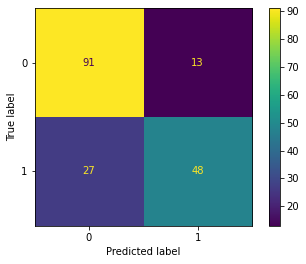

In [46]:
make_post_hoc_report(GBC, valid_data, valid_value, "GradientBoostingClassifier")

ML model name: RandomForestClassifier
ML_model parameters: 

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 19, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 500, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 200, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       104
           1       0.74      0.64      0.69        75

    accuracy                           0.75       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179

Accuracy score: 0.7541899441340782
ROC-AUC score: 0.7382692307692308


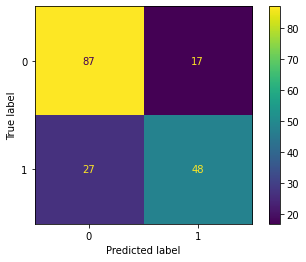

In [47]:
make_post_hoc_report(RFC, valid_data, valid_value, 'RandomForestClassifier')

ML model name: RandomForestClassifier
            Feature  Importance
14         Title_Mr    0.164311
5   Fare_Per_Person    0.127979
11         Sex_male    0.103874
6         Age*Class    0.102988
3              Fare    0.102908
10       Sex_female    0.099444
0               Age    0.070399
9          Pclass_3    0.050762
4       Family_Size    0.047788
13       Title_Miss    0.033206
1             SibSp    0.026720
7          Pclass_1    0.021614
15        Title_Mrs    0.013373
8          Pclass_2    0.012724
12     Title_Master    0.011036
2             Parch    0.010874


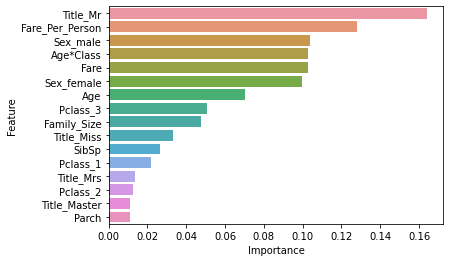

In [48]:
make_feature_importance_report(feature_imp_df_rfc, "RandomForestClassifier")

ML model name: GradientBoostingClassifier
            Feature  Importance
14         Title_Mr    0.164311
5   Fare_Per_Person    0.127979
11         Sex_male    0.103874
6         Age*Class    0.102988
3              Fare    0.102908
10       Sex_female    0.099444
0               Age    0.070399
9          Pclass_3    0.050762
4       Family_Size    0.047788
13       Title_Miss    0.033206
1             SibSp    0.026720
7          Pclass_1    0.021614
15        Title_Mrs    0.013373
8          Pclass_2    0.012724
12     Title_Master    0.011036
2             Parch    0.010874


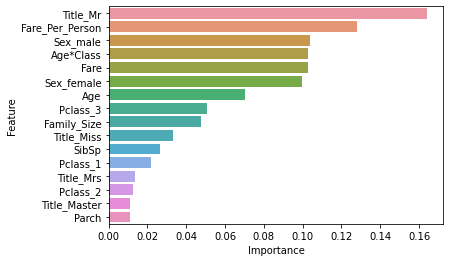

In [49]:
make_feature_importance_report(feature_imp_df_gbc, 'GradientBoostingClassifier')

# Make new model based on the knowledge of the feature importance

## a new random forest

In [50]:
def get_dfs_with_most_important_features(test_df, feature_imp_df, N_features):
    print("Number of features total: {}".format(len(train_data.columns)))
    print("Number of features selected: {}".format(N_features))
    selected_imp_features = feature_imp_df['Feature'][:N_features].to_list()
    test_df_most_imp = test_df[selected_imp_features]
    main_df_most_imp = main_df[selected_imp_features]
    return test_df_most_imp, main_df_most_imp

In [51]:
test_df_most_imp, main_df_most_imp = get_dfs_with_most_important_features(test_df, feature_imp_df_rfc, 8)

Number of features total: 16
Number of features selected: 8


In [52]:
train_data, valid_data, train_value, valid_value  = train_test_split(main_df_most_imp, Survived, test_size = 0.2, random_state = rand_state, shuffle = True)

In [53]:
RFC_new = get_random_forest_model()

In [54]:
RFC_new.fit(train_data, train_value)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy', max_depth=19,
                                              min_samples_leaf=5,
                                              min_samples_split=10,
                                              random_state=200),
             param_grid=[{'max_samples': [200, 300, 500],
                          'n_estimators': [300, 500, 1000]}])

ML model name: RandomForestClassifier
ML_model parameters: 

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 19, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 500, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 200, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       104
           1       0.77      0.63      0.69        75

    accuracy                           0.77       179
   macro avg       0.77      0.75      0.75       179
weighted avg       0.77      0.77      0.76       179

Accuracy score: 0.7653631284916201
ROC-AUC score: 0.7460256410256411


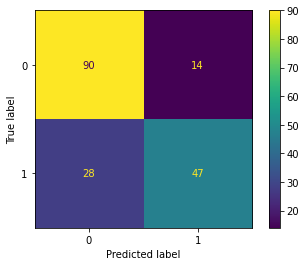

In [55]:
make_post_hoc_report(RFC_new, valid_data, valid_value, 'RandomForestClassifier')

In [56]:
make_csv_sub(test_df_most_imp, PassengerID, RFC_new, 'gender_submission_rfc_new.csv')

## a new gradient boosting classificator

In [57]:
test_df_most_imp, main_df_most_imp = get_dfs_with_most_important_features(test_df, feature_imp_df_gbc, 7)

Number of features total: 8
Number of features selected: 7


In [58]:
train_data, valid_data, train_value, valid_value  = train_test_split(main_df_most_imp, Survived, test_size = 0.2, random_state = rand_state, shuffle = True)

In [59]:
GBC_new = get_gradient_boosting_model()
GBC_new.fit(train_data, train_value)

GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  max_features='sqrt',
                                                  min_samples_leaf=5,
                                                  min_samples_split=10,
                                                  random_state=200),
             param_grid=[{'max_depth': [5, 7, 9],
                          'n_estimators': [100, 200, 300, 500]}])

ML model name: GradientBoostingClassifier
ML_model parameters: 

 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': 200, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       104
           1       0.77      0.63      0.69        75

    accuracy                           0.77       179
   macro avg       0.77      0.75      0.75       179
weighted avg       0.77      0.77      0.76       179

Accuracy score: 0.7653631284916201
ROC-AUC score: 0.7460256410256411


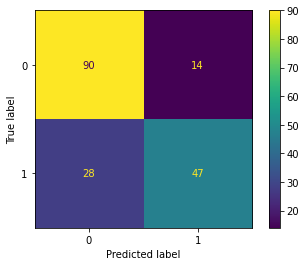

In [60]:
make_post_hoc_report(GBC_new, valid_data, valid_value, 'GradientBoostingClassifier')

In [61]:
make_csv_sub(test_df_most_imp, PassengerID, GBC_new, 'gender_submission_gbc_new.csv')